# Spotify Million Playlist Dataset - Initial Exploration

In [2]:
# This notebook explores the structure and characteristics of the MPD data
# to understand patterns that will inform our recommendation system design.

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
# ============================================================================
# 1. DATA LOADING FUNCTIONS
# ============================================================================

def load_single_slice(file_path):
    """Load a single MPD slice file"""
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

def get_slice_files(data_dir):
    """Get all MPD slice file paths"""
    data_path = Path(data_dir)
    slice_files = list(data_path.glob("mpd.slice.*.json"))
    return sorted(slice_files)

def sample_playlists(data_dir, n_files=5):
    """Load a sample of playlists from the first n files for exploration"""
    slice_files = get_slice_files(data_dir)
    
    all_playlists = []
    files_processed = 0

    print(f" Loading sample from first {n_files} files...")
    
    for file_path in slice_files[:n_files]:
        print(f"   Loading: {file_path.name}")
        data = load_single_slice(file_path)
        all_playlists.extend(data['playlists'])
        files_processed += 1
        
    print(f" Loaded {len(all_playlists)} playlists from {files_processed} files")
    return all_playlists

In [4]:
# Load sample data (adjust path to your data directory)
DATA_DIR = "../../data/raw"  # Update this to your actual data path
sample_playlists = sample_playlists(DATA_DIR, n_files=3)

print(f"\n Basic Dataset Statistics")
print(f"Number of playlists in sample: {len(sample_playlists)}")

# Examine first playlist structure
first_playlist = sample_playlists[0]
print(f"\n🎭 Sample Playlist Structure:")
print(f"Playlist ID: {first_playlist['pid']}")
print(f"Name: '{first_playlist['name']}'")
print(f"Number of tracks: {first_playlist['num_tracks']}")
print(f"Number of artists: {first_playlist['num_artists']}")
print(f"Number of albums: {first_playlist['num_albums']}")
print(f"Followers: {first_playlist['num_followers']}")

print(f"\n🎵 Sample tracks from '{first_playlist['name']}':")
for i, track in enumerate(first_playlist['tracks'][:5]):
    print(f"  {i+1}. {track['track_name']} - {track['artist_name']}")

 Loading sample from first 3 files...
   Loading: mpd.slice.0-999.json
   Loading: mpd.slice.1000-1999.json
   Loading: mpd.slice.10000-10999.json
 Loaded 3000 playlists from 3 files

 Basic Dataset Statistics
Number of playlists in sample: 3000

🎭 Sample Playlist Structure:
Playlist ID: 0
Name: 'Throwbacks'
Number of tracks: 52
Number of artists: 37
Number of albums: 47
Followers: 1

🎵 Sample tracks from 'Throwbacks':
  1. Lose Control (feat. Ciara & Fat Man Scoop) - Missy Elliott
  2. Toxic - Britney Spears
  3. Crazy In Love - Beyoncé
  4. Rock Your Body - Justin Timberlake
  5. It Wasn't Me - Shaggy


In [5]:
# ============================================================================
# 3. PLAYLIST CHARACTERISTICS ANALYSIS
# ============================================================================

def analyze_playlist_characteristics(playlists):
    """Analyze basic characteristics of playlists"""
    
    stats = {
        'num_tracks': [],
        'num_artists': [],
        'num_albums': [],
        'num_followers': [],
        'num_edits': [],
        'collaborative': [],
        'name_length': [],
        'has_description': []
    }
    
    for playlist in playlists:
        stats['num_tracks'].append(playlist['num_tracks'])
        stats['num_artists'].append(playlist['num_artists'])
        stats['num_albums'].append(playlist['num_albums'])
        stats['num_followers'].append(playlist['num_followers'])
        stats['num_edits'].append(playlist['num_edits'])
        stats['collaborative'].append(playlist['collaborative'])
        stats['name_length'].append(len(playlist['name']))
        stats['has_description'].append('description' in playlist)
    
    return stats

print(f"\n Analyzing Playlist Characteristics...")
playlist_stats = analyze_playlist_characteristics(sample_playlists)

# Convert to DataFrame for easier analysis
df_stats = pd.DataFrame(playlist_stats)

print(f"\n Playlist Statistics Summary:")
print(df_stats.describe())


 Analyzing Playlist Characteristics...

 Playlist Statistics Summary:
        num_tracks  num_artists   num_albums  num_followers    num_edits  \
count  3000.000000  3000.000000  3000.000000    3000.000000  3000.000000   
mean     66.924333    38.391667    49.802000       1.905000    17.887667   
std      54.479347    30.655084    40.226146      19.098313    21.409542   
min       5.000000     3.000000     2.000000       1.000000     2.000000   
25%      26.000000    16.000000    20.000000       1.000000     4.000000   
50%      50.000000    30.000000    37.000000       1.000000    10.000000   
75%      92.000000    52.000000    69.000000       1.000000    22.000000   
max     250.000000   187.000000   229.000000    1038.000000   178.000000   

       name_length  
count  3000.000000  
mean      7.696333  
std       4.295999  
min       2.000000  
25%       5.000000  
50%       7.000000  
75%      10.000000  
max      52.000000  


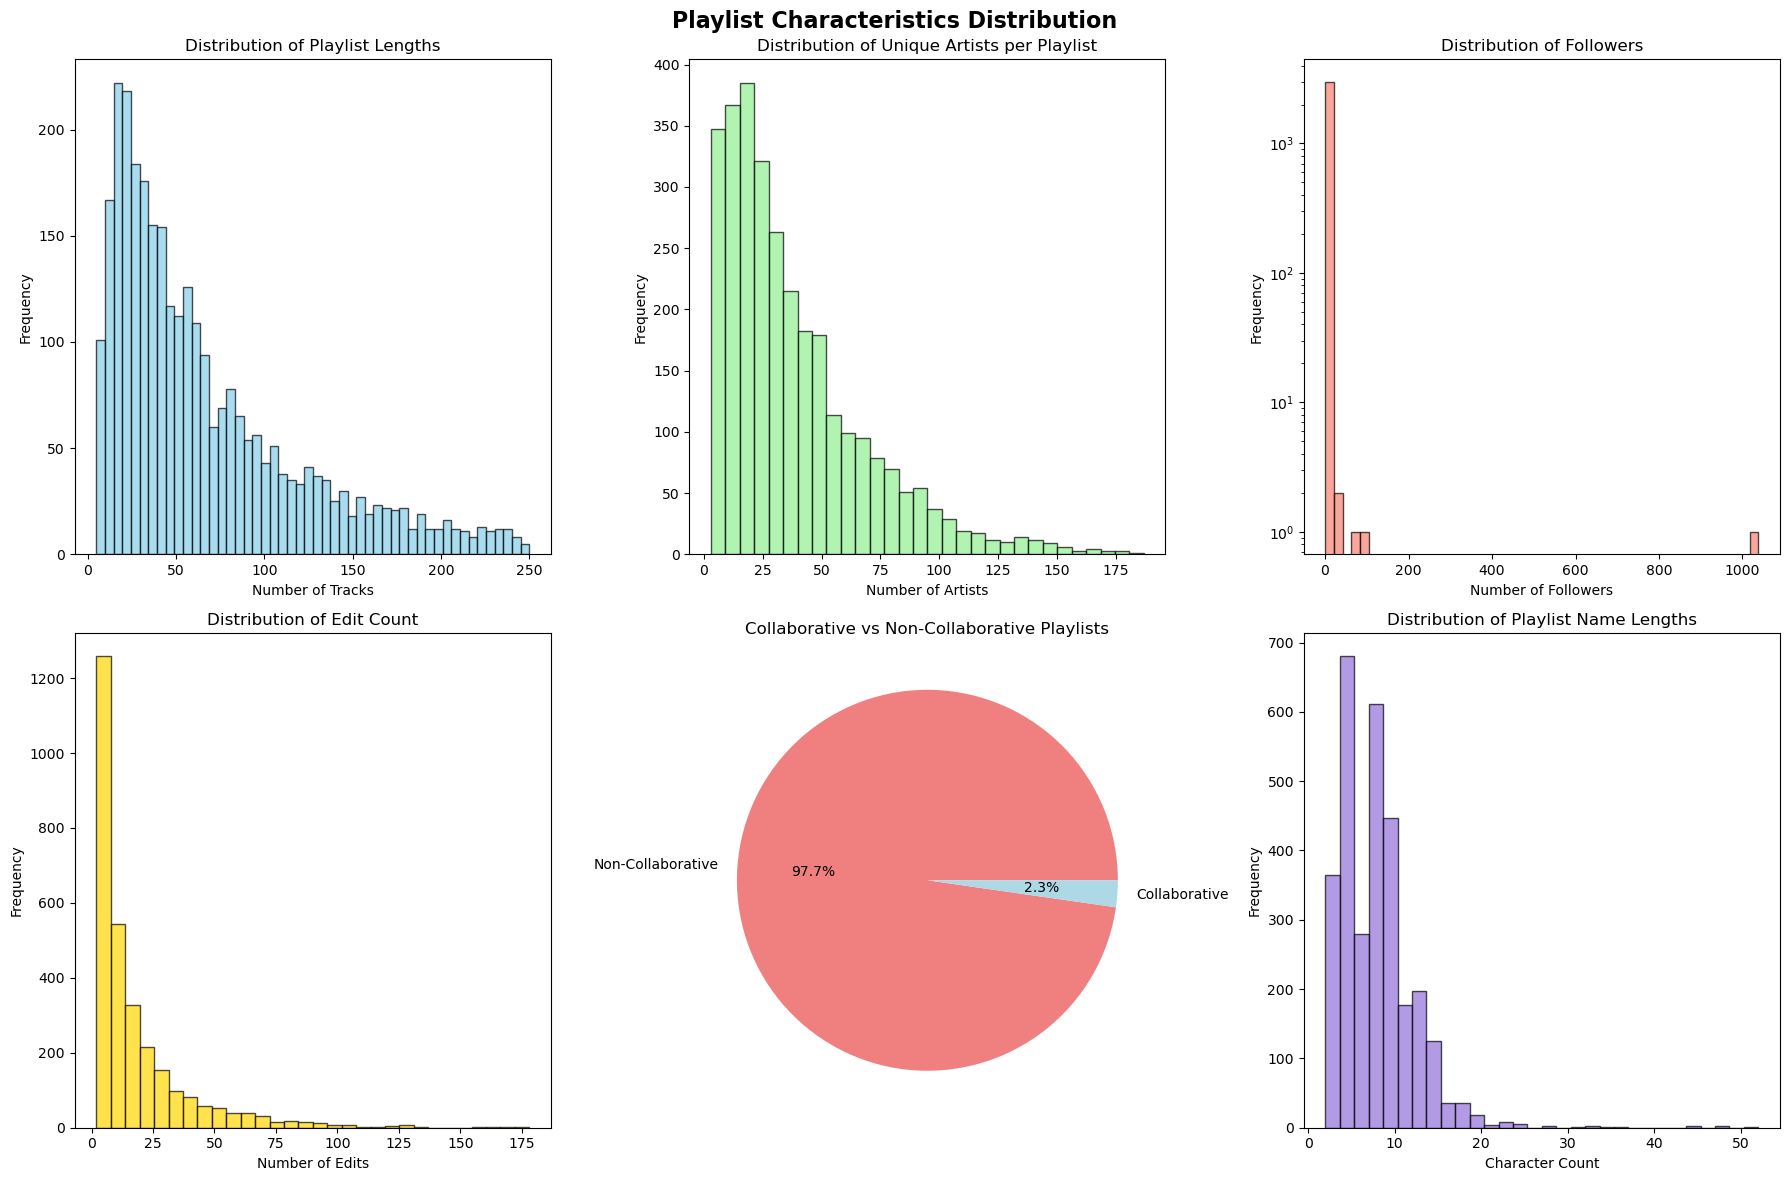

In [6]:
# ============================================================================
# 4. VISUALIZATION: PLAYLIST CHARACTERISTICS
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Playlist Characteristics Distribution', fontsize=16, fontweight='bold')

# Number of tracks distribution
axes[0, 0].hist(df_stats['num_tracks'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Playlist Lengths')
axes[0, 0].set_xlabel('Number of Tracks')
axes[0, 0].set_ylabel('Frequency')

# Number of artists distribution
axes[0, 1].hist(df_stats['num_artists'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Distribution of Unique Artists per Playlist')
axes[0, 1].set_xlabel('Number of Artists')
axes[0, 1].set_ylabel('Frequency')

# Number of followers (log scale due to skewness)
axes[0, 2].hist(df_stats['num_followers'], bins=50, alpha=0.7, color='salmon', edgecolor='black')
axes[0, 2].set_title('Distribution of Followers')
axes[0, 2].set_xlabel('Number of Followers')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_yscale('log')

# Number of edits
axes[1, 0].hist(df_stats['num_edits'], bins=30, alpha=0.7, color='gold', edgecolor='black')
axes[1, 0].set_title('Distribution of Edit Count')
axes[1, 0].set_xlabel('Number of Edits')
axes[1, 0].set_ylabel('Frequency')

# Collaborative vs non-collaborative
collab_counts = df_stats['collaborative'].value_counts()
axes[1, 1].pie(collab_counts.values, labels=['Non-Collaborative', 'Collaborative'], 
               autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
axes[1, 1].set_title('Collaborative vs Non-Collaborative Playlists')

# Playlist name length
axes[1, 2].hist(df_stats['name_length'], bins=30, alpha=0.7, color='mediumpurple', edgecolor='black')
axes[1, 2].set_title('Distribution of Playlist Name Lengths')
axes[1, 2].set_xlabel('Character Count')
axes[1, 2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [7]:
# ============================================================================
# 5. TRACK ANALYSIS
# ============================================================================

def analyze_tracks(playlists):
    """Analyze track characteristics across playlists"""
    
    all_tracks = []
    track_counter = Counter()
    artist_counter = Counter()
    album_counter = Counter()
    
    for playlist in playlists:
        for track in playlist['tracks']:
            track_info = {
                'track_uri': track['track_uri'],
                'track_name': track['track_name'],
                'artist_name': track['artist_name'],
                'album_name': track['album_name'],
                'duration_ms': track['duration_ms'],
                'playlist_id': playlist['pid']
            }
            all_tracks.append(track_info)
            
            # Count occurrences
            track_key = f"{track['track_name']} - {track['artist_name']}"
            track_counter[track_key] += 1
            artist_counter[track['artist_name']] += 1
            album_counter[track['album_name']] += 1
    
    return all_tracks, track_counter, artist_counter, album_counter

print(f"\n Analyzing Track Data...")
tracks, track_counts, artist_counts, album_counts = analyze_tracks(sample_playlists)

print(f"\nTrack Statistics:")
print(f"Total tracks: {len(tracks)}")
print(f"Unique tracks: {len(track_counts)}")
print(f"Unique artists: {len(artist_counts)}")
print(f"Unique albums: {len(album_counts)}")


 Analyzing Track Data...

Track Statistics:
Total tracks: 200773
Unique tracks: 75388
Unique artists: 18729
Unique albums: 34800



 Most Popular Tracks (in sample):
 1. HUMBLE. - Kendrick Lamar (145 playlists)
 2. Closer - The Chainsmokers (144 playlists)
 3. One Dance - Drake (141 playlists)
 4. Broccoli (feat. Lil Yachty) - DRAM (138 playlists)
 5. Congratulations - Post Malone (133 playlists)
 6. Bad and Boujee (feat. Lil Uzi Vert) - Migos (126 playlists)
 7. Caroline - Aminé (119 playlists)
 8. Location - Khalid (115 playlists)
 9. XO TOUR Llif3 - Lil Uzi Vert (114 playlists)
10. goosebumps - Travis Scott (110 playlists)

 Most Popular Artists (in sample):
 1. Drake (2840 tracks)
 2. Kanye West (1298 tracks)
 3. Kendrick Lamar (1132 tracks)
 4. Rihanna (1037 tracks)
 5. The Weeknd (955 tracks)
 6. Future (818 tracks)
 7. Beyoncé (793 tracks)
 8. Eminem (791 tracks)
 9. Ed Sheeran (788 tracks)
10. Justin Bieber (710 tracks)


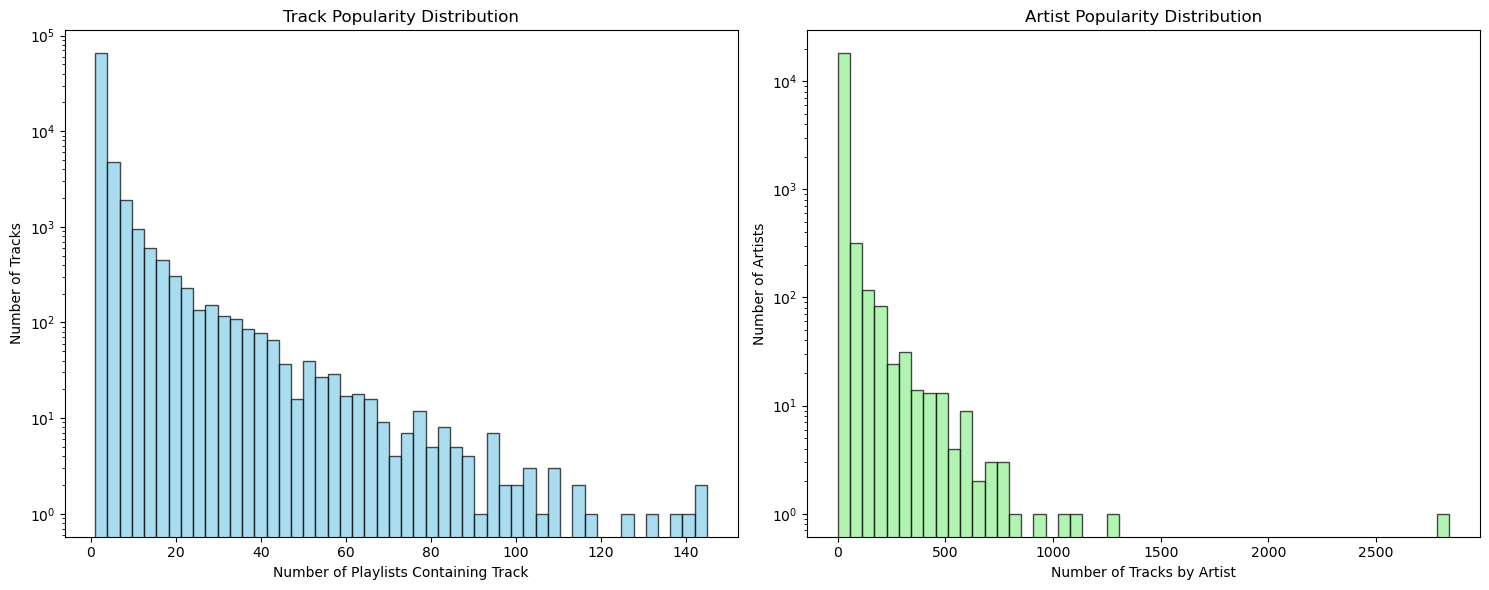

In [8]:
# ============================================================================
# 6. POPULARITY ANALYSIS
# ============================================================================

print(f"\n Most Popular Tracks (in sample):")
for i, (track, count) in enumerate(track_counts.most_common(10), 1):
    print(f"{i:2d}. {track} ({count} playlists)")

print(f"\n Most Popular Artists (in sample):")
for i, (artist, count) in enumerate(artist_counts.most_common(10), 1):
    print(f"{i:2d}. {artist} ({count} tracks)")

# Create popularity distribution plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Track popularity distribution
track_popularity = list(track_counts.values())
ax1.hist(track_popularity, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_title('Track Popularity Distribution')
ax1.set_xlabel('Number of Playlists Containing Track')
ax1.set_ylabel('Number of Tracks')
ax1.set_yscale('log')

# Artist popularity distribution
artist_popularity = list(artist_counts.values())
ax2.hist(artist_popularity, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
ax2.set_title('Artist Popularity Distribution')
ax2.set_xlabel('Number of Tracks by Artist')
ax2.set_ylabel('Number of Artists')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

In [11]:
# ============================================================================
# 7. PLAYLIST NAME ANALYSIS
# ============================================================================

def analyze_playlist_names(playlists):
    """Analyze playlist names for common patterns"""
    
    name_counter = Counter()
    word_counter = Counter()
    
    for playlist in playlists:
        name = playlist['name'].lower().strip()
        name_counter[name] += 1
        
        # Extract words (simple tokenization)
        words = name.replace(',', ' ').replace('.', ' ').split()
        for word in words:
            if len(word) > 2:  # Filter out very short words
                word_counter[word] += 1
    
    return name_counter, word_counter

print(f"\n Analyzing Playlist Names...")
name_counts, word_counts = analyze_playlist_names(sample_playlists)

print(f"\n Most Common Playlist Names (in sample):")
for i, (name, count) in enumerate(name_counts.most_common(10), 1):
    print(f"{i:2d}. '{name}' ({count} playlists)")

print(f"\n Most Common Words in Playlist Names (in sample):")
for i, (word, count) in enumerate(word_counts.most_common(15), 1):
    print(f"{i:2d}. '{word}' ({count} occurrences)")


 Analyzing Playlist Names...

 Most Common Playlist Names (in sample):
 1. 'country' (79 playlists)
 2. 'chill' (48 playlists)
 3. 'rap' (29 playlists)
 4. 'workout' (27 playlists)
 5. 'party' (27 playlists)
 6. 'christmas' (25 playlists)
 7. 'rock' (25 playlists)
 8. 'oldies' (22 playlists)
 9. 'feels' (16 playlists)
10. 'disney' (15 playlists)

 Most Common Words in Playlist Names (in sample):
 1. 'country' (113 occurrences)
 2. 'songs' (85 occurrences)
 3. 'chill' (76 occurrences)
 4. 'music' (76 occurrences)
 5. 'summer' (66 occurrences)
 6. 'rock' (63 occurrences)
 7. 'party' (59 occurrences)
 8. 'playlist' (53 occurrences)
 9. 'rap' (50 occurrences)
10. 'good' (48 occurrences)
11. 'new' (45 occurrences)
12. 'mix' (43 occurrences)
13. 'workout' (42 occurrences)
14. 'christmas' (40 occurrences)
15. 'the' (34 occurrences)


In [12]:
# ============================================================================
# 8. SUMMARY AND INSIGHTS
# ============================================================================

print(f"\n" + "="*60)
print(f" KEY INSIGHTS FROM EXPLORATORY DATA ANALYSIS")
print(f"="*60)

avg_tracks = np.mean(df_stats['num_tracks'])
avg_artists = np.mean(df_stats['num_artists'])
avg_albums = np.mean(df_stats['num_albums'])

print(f"\n Playlist Characteristics:")
print(f"   • Average playlist length: {avg_tracks:.1f} tracks")
print(f"   • Average unique artists per playlist: {avg_artists:.1f}")
print(f"   • Average unique albums per playlist: {avg_albums:.1f}")
print(f"   • Artist-to-track ratio: {avg_artists/avg_tracks:.2f}")

print(f"\n Content Diversity:")
print(f"   • Unique tracks in sample: {len(track_counts):,}")
print(f"   • Unique artists in sample: {len(artist_counts):,}")
print(f"   • Track reuse rate: {len(tracks)/len(track_counts):.2f}x")

# Fix the collaborative percentage calculation
collaborative_count = sum(1 for val in df_stats['collaborative'] if val == True or val == 'true' or val == 'True')
total_playlists = len(df_stats)
collaborative_pct = (collaborative_count / total_playlists) * 100

print(f"\n User Behavior:")
print(f"   • Collaborative playlists: {collaborative_pct:.1f}%")
print(f"   • Average edits per playlist: {np.mean(df_stats['num_edits']):.1f}")

print(f"\n Popularity Patterns:")
most_popular_track = track_counts.most_common(1)[0]
print(f"   • Most popular track appears in {most_popular_track[1]} playlists")
print(f"   • Long tail: {sum(1 for count in track_counts.values() if count == 1)} tracks appear only once")

print(f"\n" + "="*60)
print(f"✅ EDA Complete! Ready for next phase of analysis.")
print(f"="*60)


 KEY INSIGHTS FROM EXPLORATORY DATA ANALYSIS

 Playlist Characteristics:
   • Average playlist length: 66.9 tracks
   • Average unique artists per playlist: 38.4
   • Average unique albums per playlist: 49.8
   • Artist-to-track ratio: 0.57

 Content Diversity:
   • Unique tracks in sample: 75,388
   • Unique artists in sample: 18,729
   • Track reuse rate: 2.66x

 User Behavior:
   • Collaborative playlists: 2.3%
   • Average edits per playlist: 17.9

 Popularity Patterns:
   • Most popular track appears in 145 playlists
   • Long tail: 50951 tracks appear only once

✅ EDA Complete! Ready for next phase of analysis.
